# Evaluation using QCB chemicals (large)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists
import copy

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns

from stable_baselines3 import DQN, PPO
from sb3_contrib import RecurrentPPO, MaskablePPO

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, \
    METHOD_DQN_COV, METHOD_DQN_INT, METHOD_DQN_MID, METHOD_PPO, METHOD_PPO_RECURRENT
from vimms_gym.experiments import preset_qcb_large

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [5]:
env_alpha = 0.25
env_beta = 0.50
extract = True
params, max_peaks = preset_qcb_large(None, alpha=env_alpha, beta=env_beta, extract_chromatograms=extract)
params, max_peaks

2023-04-04 16:31:48.893 | INFO     | vimms_gym.experiments:get_samplers:303 - Loaded /Users/joewandy/Work/git/vimms-gym/pickles/samplers_QCB_large_extracted.p


({'chemical_creator': {'mz_range': (70, 1000),
   'rt_range': (0, 1440),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (2000, 5000),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f845e023280>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f845e0a5cc0>,
   'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f843a6e7220>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (70, 1000)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (0, 1440),
   'isolation_window': 0.7,
   'use_dew': False,
   'mz_tol': 10,
   'rt_tol': 5,
   'min_ms1_intensity': 5000,
   'alpha': 0.25,
   'beta': 0.5}},
 100)

In [6]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (400, 800)
# intensity_range = (1E4, 1E20)

Evaluation parameters

In [7]:
env_name = 'DDAEnv'
intensity_threshold = 0.5

dqn_in_dir = 'DQN_2.0E5'

# ppo_in_dir = os.path.join('..', '..', 'tune', 'QCB_resimulated_medium')
ppo_in_dir = 'PPO_2.0E5'

methods = [
    METHOD_RANDOM,
    METHOD_PPO,
    # METHOD_DQN,        
    METHOD_TOPN,
]
valid_random = True
n_eval_episodes = 30

In [8]:
# topN parameters
topN_N = 15
topN_rt_tol = 15
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 0.5
ils = 5
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 3
t1 = 240
weighteddew_N = 15

## Generate chemical sets for evaluation

In [9]:
fname = 'QCB_chems_large.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

2151
4096
3307
3000
4490
2477
3302
2370
3021
3051
4873
3756
4904
3460
2023
4151
4326
4131
4881
3491
3674
4196
2541
3254
4358
3301
4916
2655
4538
3171


Generate new chemicals if not found

In [10]:
params['chemical_creator']

{'mz_range': (70, 1000),
 'rt_range': (0, 1440),
 'intensity_range': (10000.0, 1e+20),
 'n_chemicals': (2000, 5000),
 'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f845e023280>,
 'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f845e0a5cc0>,
 'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f843a6e7220>}

In [11]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    
    chemical_creator_params = params['chemical_creator']
    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [12]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

30

# 2. Evaluation

In [13]:
set_log_level_warning()

1

In [14]:
params

{'chemical_creator': {'mz_range': (70, 1000),
  'rt_range': (0, 1440),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (2000, 5000),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f845e023280>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f845e0a5cc0>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f843a6e7220>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (70, 1000)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (0, 1440),
  'isolation_window': 0.7,
  'use_dew': False,
  'mz_tol': 10,
  'rt_tol': 5,
  'min_ms1_intensity': 5000,
  'alpha': 0.25,
  'beta': 0.5}}

In [15]:
horizon = 1
out_dir = 'evaluation_2.0E5_horizon_%d_alpha_%.2f_beta_%.2f' % (horizon, env_alpha, env_beta)

In [16]:
method_eval_results = {}
for method in methods:

    N = 0
    copy_params = copy.deepcopy(params)            
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    if method == METHOD_DQN:
        
        fname = os.path.join(dqn_in_dir, '%s_%s_alpha_%.2f_beta_%.2f_horizon_%d.zip' % (env_name, method, env_alpha, env_beta, horizon))
        # fname = os.path.join(dqn_in_dir, 'metric_reward_timesteps_1.0E6_alpha_%.2f_beta_%.2f' % (env_alpha, env_beta), method, 'best_model.zip')
        
        model = DQN.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = env_alpha
        copy_params['env']['beta'] = env_beta                

    elif method == METHOD_PPO:
        
        fname = os.path.join(ppo_in_dir, '%s_%s_alpha_%.2f_beta_%.2f_horizon_%d.zip' % (env_name, method, env_alpha, env_beta, horizon))
        # fname = os.path.join(ppo_in_dir, 'metric_reward_timesteps_1.0E5_alpha_%.2f_beta_%.2f' % (env_alpha, env_beta), method, 'best_model.zip')
        
        model = MaskablePPO.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = env_alpha
        copy_params['env']['beta'] = env_beta                
        
    else:
        model = None
        if method == METHOD_TOPN:
            N = topN_N
            effective_rt_tol = topN_rt_tol
            copy_params = dict(params)
            copy_params['env']['use_dew'] = True
            copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method = %s max_peaks = %d N = %d rt_tol = %d' % (method, max_peaks, N, 
                                                                                   copy_params['env']['rt_tol'])
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=True, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method, horizon=horizon, valid_random=valid_random)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method = random max_peaks = 100 N = 0 rt_tol = 5


Episode 0 (2151 chemicals)
steps	 500 	total rewards	 42.791271713931636
steps	 1000 	total rewards	 108.76504707178033
steps	 1500 	total rewards	 183.25437743387857
steps	 2000 	total rewards	 258.7983328430736
steps	 2500 	total rewards	 339.6868946026862
steps	 3000 	total rewards	 423.68151726454414
steps	 3500 	total rewards	 496.2923294737274
steps	 4000 	total rewards	 556.6229043457927
steps	 4500 	total rewards	 610.1609689757832
steps	 5000 	total rewards	 666.9768703731168
steps	 5500 	total rewards	 729.0408570384592
steps	 6000 	total rewards	 786.9392916236625
steps	 6500 	total rewards	 842.1811242771455
Finished after 6617 timesteps (21.6585910320282 seconds) with total reward 853.205872239095
{'coverage_prop': '0.737', 'intensity_prop': '0.480', 'ms1ms2_ratio': '0.097', 'efficiency': '0.263', 'TP': '1148', 'FP': '438', 'FN': '565', 'precision': '0.724', 'recall': '0.670', 'f1': '0.696', 'total_rewards': 853.2058722390

#### Test classic controllers in ViMMS

In [17]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [18]:
params

{'chemical_creator': {'mz_range': (70, 1000),
  'rt_range': (0, 1440),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (2000, 5000),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f845e023280>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f845e0a5cc0>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f843a6e7220>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (70, 1000)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (0, 1440),
  'isolation_window': 0.7,
  'use_dew': True,
  'mz_tol': 10,
  'rt_tol': 15,
  'min_ms1_intensity': 5000,
  'alpha': 0.25,
  'beta': 0.5}}

In [19]:
enable_spike_noise = params['noise']['enable_spike_noise']
ionisation_mode = params['env']['ionisation_mode']
isolation_window = params['env']['isolation_window']
mz_tol = params['env']['mz_tol']
rt_range = params['chemical_creator']['rt_range']

In [20]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()
    
method_eval_results[method] = eval_results

method = TopN_Controller

Episode 0 finished
{'coverage_prop': '0.909', 'intensity_prop': '0.594', 'ms1ms2_ratio': '0.418', 'efficiency': '0.499', 'TP': '1450', 'FP': '506', 'FN': '195', 'precision': '0.741', 'recall': '0.881', 'f1': '0.805'}

Episode 1 finished
{'coverage_prop': '0.801', 'intensity_prop': '0.523', 'ms1ms2_ratio': '0.149', 'efficiency': '0.592', 'TP': '2435', 'FP': '846', 'FN': '815', 'precision': '0.742', 'recall': '0.749', 'f1': '0.746'}

Episode 2 finished
{'coverage_prop': '0.858', 'intensity_prop': '0.569', 'ms1ms2_ratio': '0.185', 'efficiency': '0.540', 'TP': '2153', 'FP': '684', 'FN': '470', 'precision': '0.759', 'recall': '0.821', 'f1': '0.789'}

Episode 3 finished
{'coverage_prop': '0.871', 'intensity_prop': '0.578', 'ms1ms2_ratio': '0.214', 'efficiency': '0.518', 'TP': '1985', 'FP': '628', 'FN': '387', 'precision': '0.760', 'recall': '0.837', 'f1': '0.796'}

Episode 4 finished
{'coverage_prop': '0.804', 'intensity_prop': '0.523', 'ms1ms2_ratio': '0.144', 'eff

Run SmartROI Controller

In [21]:
smartroi_N, smartroi_dew, alpha, beta, ils

(15, 15, 2, 0.5, 5)

In [22]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0, dew=smartroi_dew, initial_length_seconds=ils)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

Episode 0 finished
{'coverage_prop': '0.950', 'intensity_prop': '0.623', 'ms1ms2_ratio': '0.886', 'efficiency': '0.786', 'TP': '1507', 'FP': '536', 'FN': '108', 'precision': '0.738', 'recall': '0.933', 'f1': '0.824'}

Episode 1 finished
{'coverage_prop': '0.870', 'intensity_prop': '0.563', 'ms1ms2_ratio': '0.451', 'efficiency': '0.941', 'TP': '2603', 'FP': '959', 'FN': '534', 'precision': '0.731', 'recall': '0.830', 'f1': '0.777'}

Episode 2 finished
{'coverage_prop': '0.911', 'intensity_prop': '0.600', 'ms1ms2_ratio': '0.556', 'efficiency': '0.884', 'TP': '2260', 'FP': '753', 'FN': '294', 'precision': '0.750', 'recall': '0.885', 'f1': '0.812'}

Episode 3 finished
{'coverage_prop': '0.925', 'intensity_prop': '0.614', 'ms1ms2_ratio': '0.606', 'efficiency': '0.852', 'TP': '2076', 'FP': '698', 'FN': '226', 'precision': '0.748', 'recall': '0.902', 'f1': '0.818'}

Episode 4 finished
{'coverage_prop': '0.869', 'intensity_prop': '0.568', 'ms1ms2_ratio': '0.413', 

Run WeightedDEW Controller

In [23]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

Episode 0 finished
{'coverage_prop': '0.952', 'intensity_prop': '0.689', 'ms1ms2_ratio': '0.122', 'efficiency': '0.353', 'TP': '1735', 'FP': '312', 'FN': '104', 'precision': '0.848', 'recall': '0.943', 'f1': '0.893'}

Episode 1 finished
{'coverage_prop': '0.870', 'intensity_prop': '0.578', 'ms1ms2_ratio': '0.113', 'efficiency': '0.608', 'TP': '2697', 'FP': '868', 'FN': '531', 'precision': '0.757', 'recall': '0.836', 'f1': '0.794'}

Episode 2 finished
{'coverage_prop': '0.917', 'intensity_prop': '0.632', 'ms1ms2_ratio': '0.113', 'efficiency': '0.516', 'TP': '2422', 'FP': '610', 'FN': '275', 'precision': '0.799', 'recall': '0.898', 'f1': '0.846'}

Episode 3 finished
{'coverage_prop': '0.930', 'intensity_prop': '0.650', 'ms1ms2_ratio': '0.103', 'efficiency': '0.467', 'TP': '2265', 'FP': '525', 'FN': '210', 'precision': '0.812', 'recall': '0.915', 'f1': '0.860'}

Episode 4 finished
{'coverage_prop': '0.874', 'intensity_prop': '0.577', 'ms1ms2_ratio': '0.099

#### Plotting

Flatten data into dataframe

In [24]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        try:
            total_rewards = float(eval_res['total_rewards'])       
        except KeyError:
            total_rewards = 0.0

        try:
            invalid_action_count = float(eval_res['invalid_action_count'])       
        except KeyError:
            invalid_action_count = 0.0

        row = (
            method, 
            total_rewards, 
            invalid_action_count,
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1ms2_ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'total_rewards', 'invalid_action_count', 
    'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 
    'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,853.205872,0.0,0.737,0.480,0.097,0.263,0.724,0.670,0.696
1,random,976.237807,0.0,0.680,0.382,0.060,0.433,0.599,0.560,0.579
2,random,970.383424,0.0,0.700,0.409,0.067,0.365,0.638,0.598,0.618
3,random,950.655100,0.0,0.733,0.433,0.063,0.344,0.644,0.638,0.641
4,random,1012.897466,0.0,0.670,0.384,0.054,0.463,0.622,0.558,0.589


In [25]:
sns.set_context("poster")

Text(0.5, 1.0, 'Total Rewards')

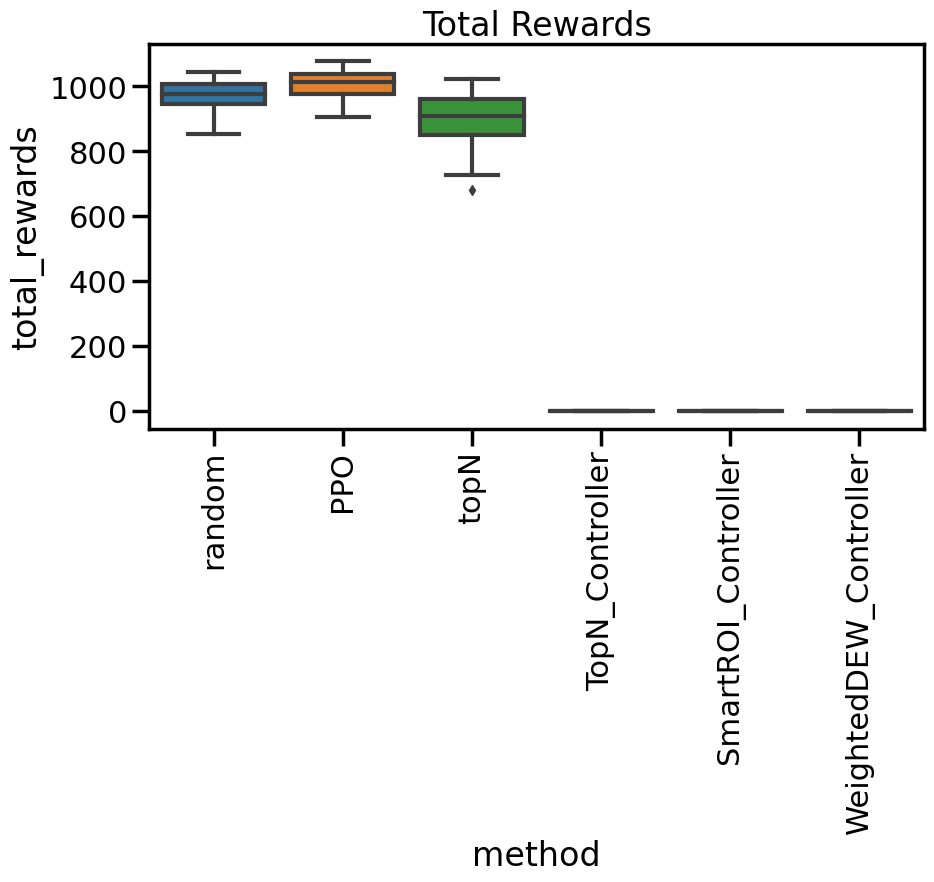

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='total_rewards')
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

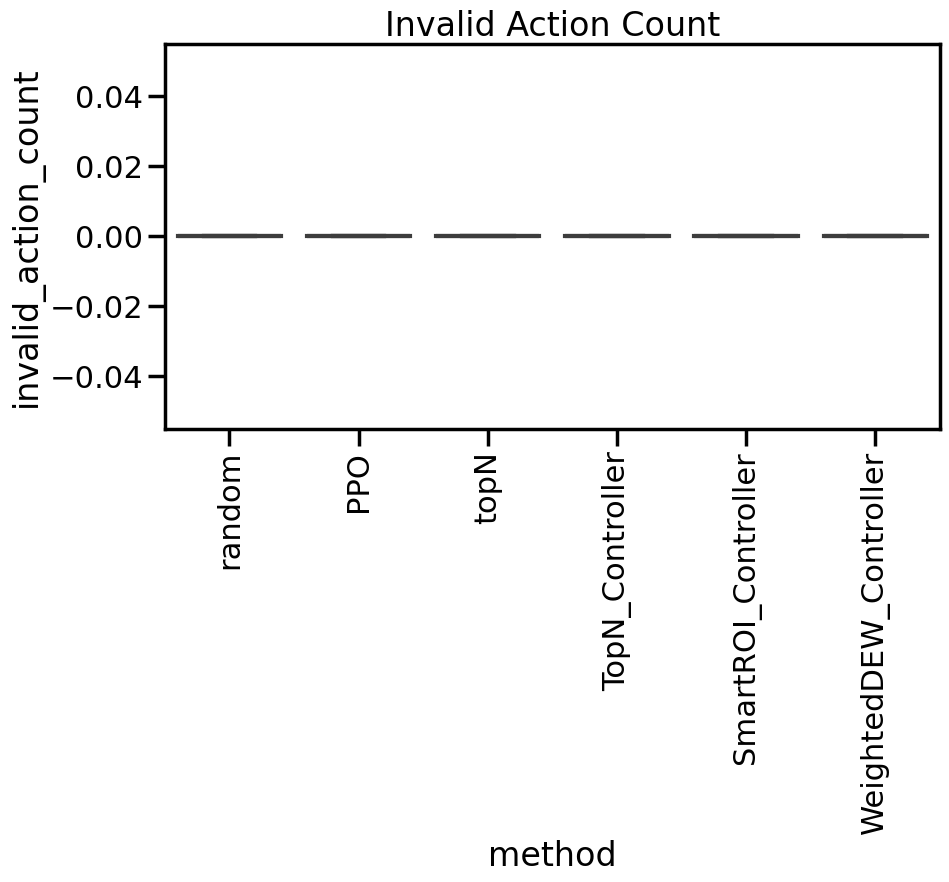

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='invalid_action_count')
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

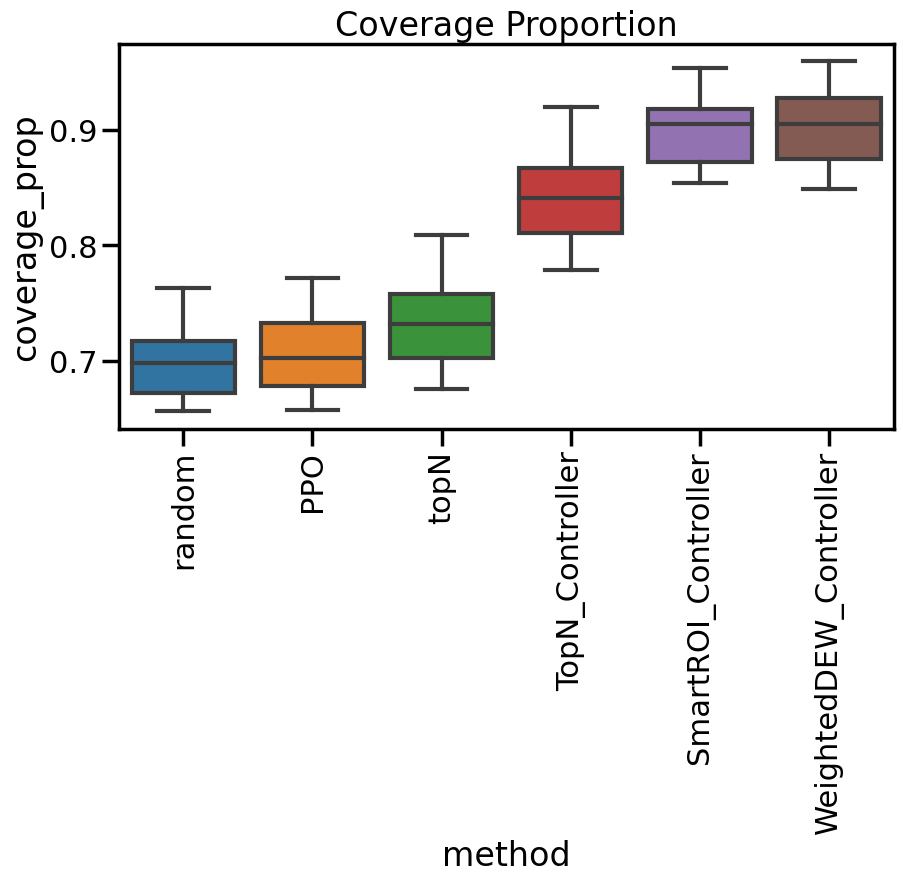

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

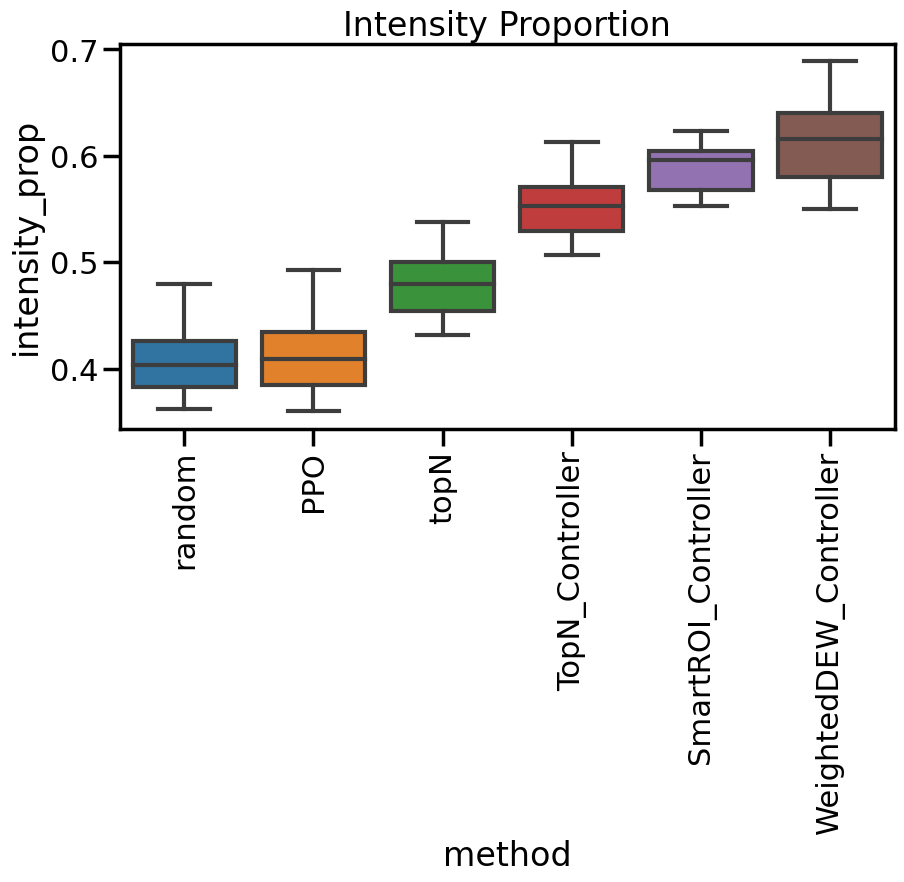

In [29]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

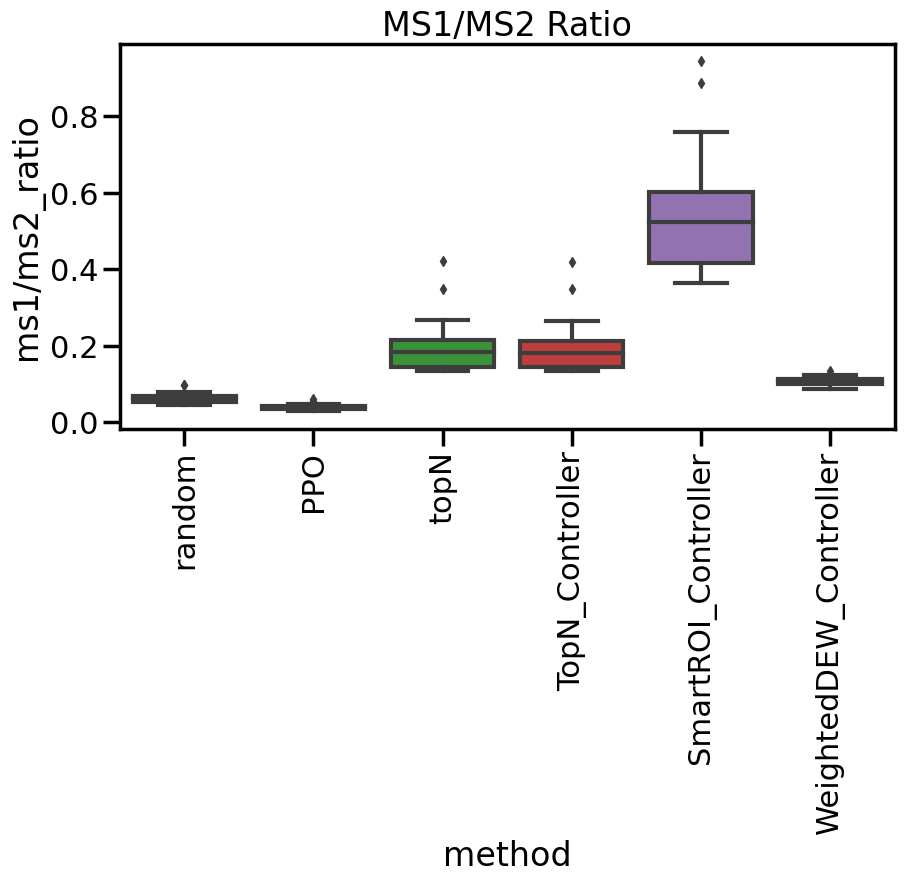

In [30]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

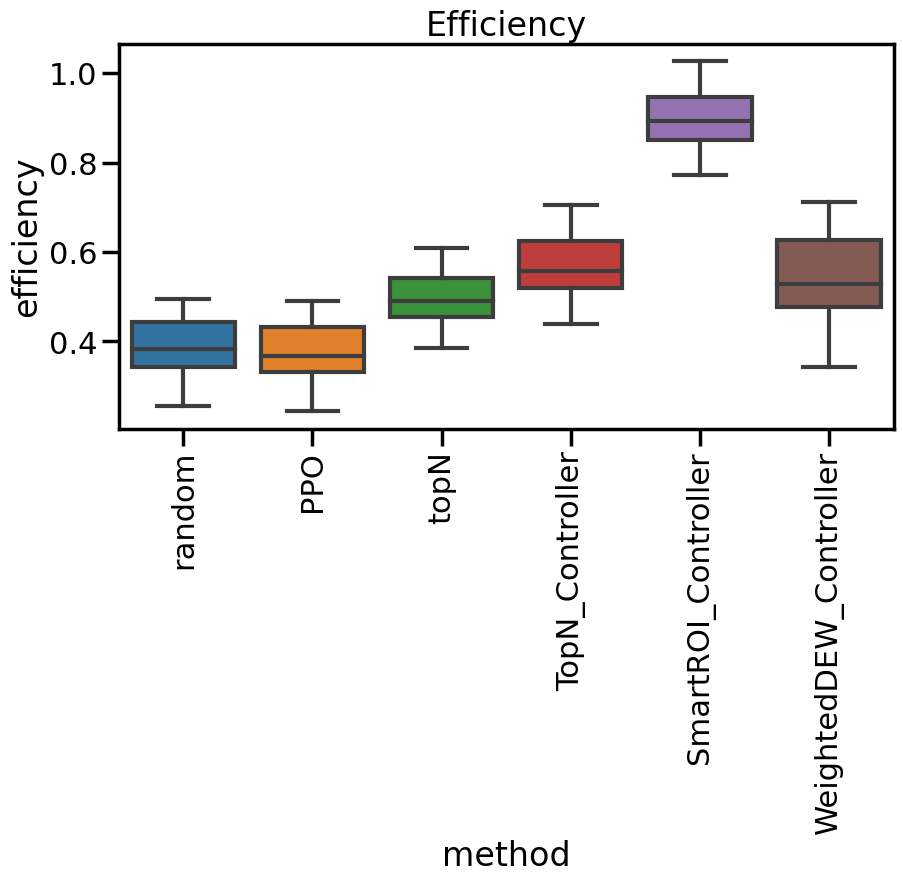

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

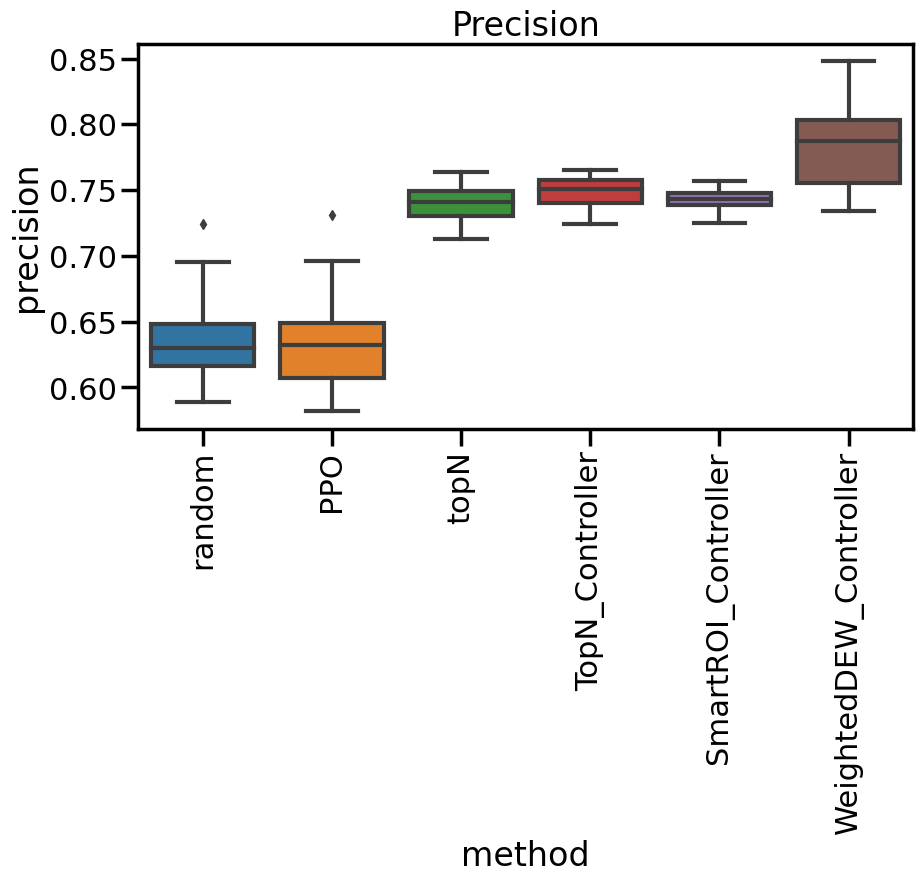

In [32]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

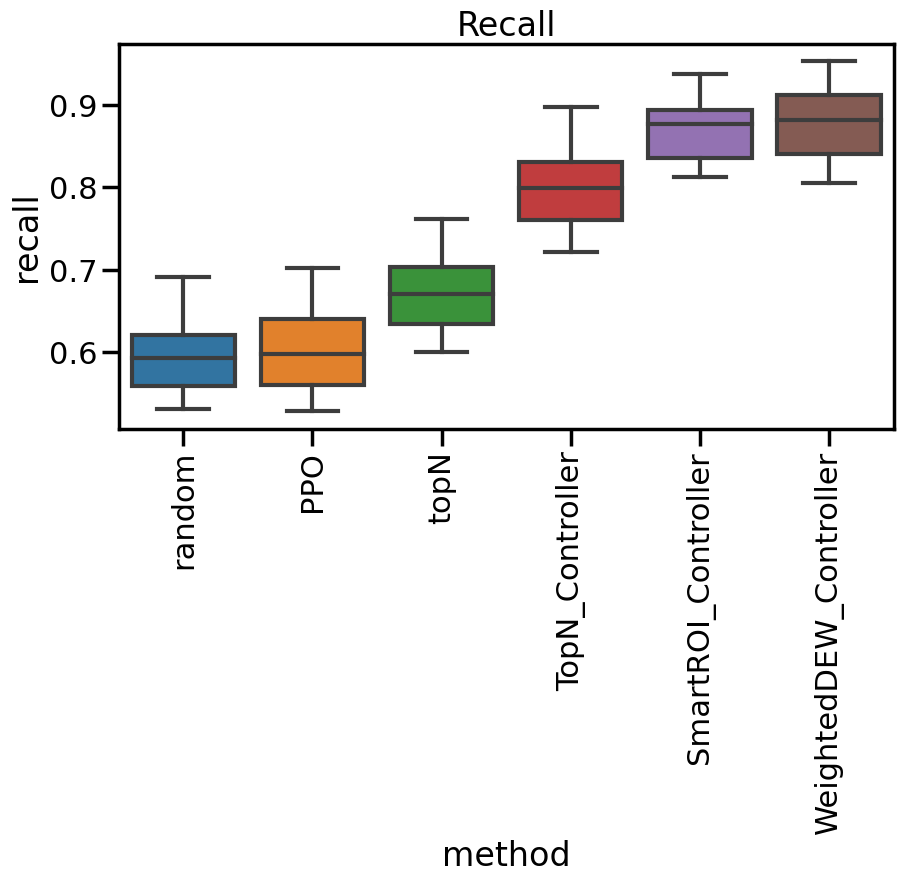

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

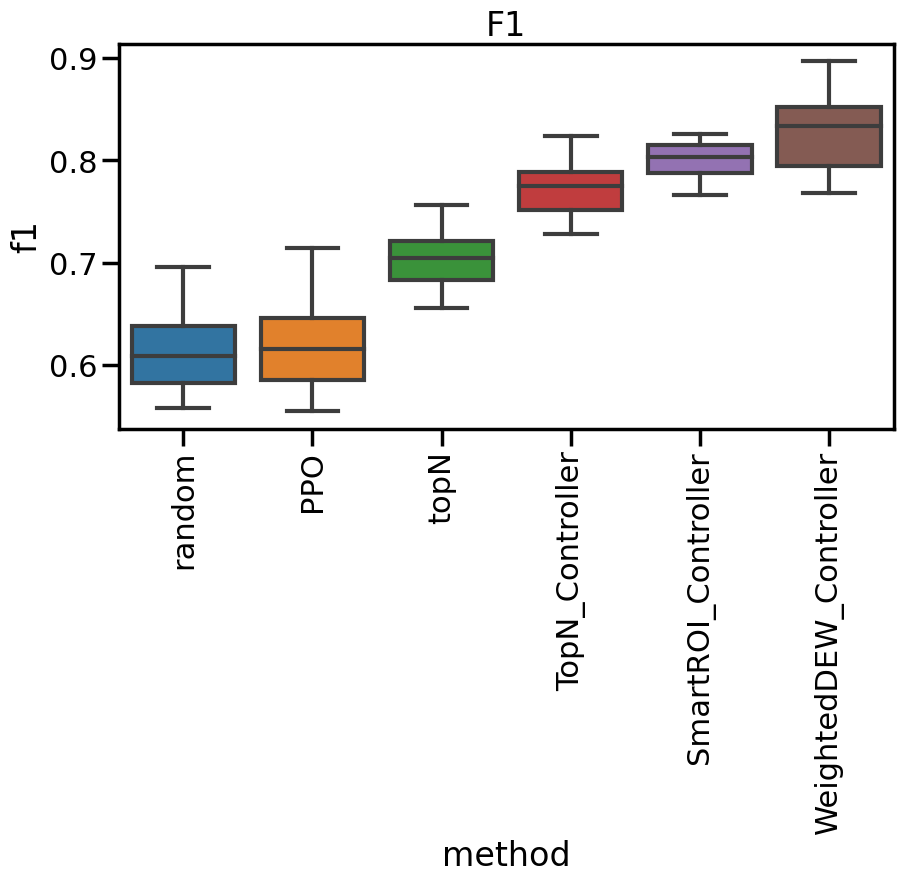

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [35]:
df.to_pickle('evaluation_2.0E5_horizon_%d_alpha_%.2f_beta_%.2f.p' % (horizon, env_alpha, env_beta))

### Without 'DQN'

In [36]:
df = pd.read_pickle('evaluation_2.0E5_horizon_%d_alpha_%.2f_beta_%.2f.p' % (horizon, env_alpha, env_beta))

In [37]:
new_df = df[df.method != 'DQN']
new_df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,853.205872,0.0,0.737,0.480,0.097,0.263,0.724,0.670,0.696
1,random,976.237807,0.0,0.680,0.382,0.060,0.433,0.599,0.560,0.579
2,random,970.383424,0.0,0.700,0.409,0.067,0.365,0.638,0.598,0.618
3,random,950.655100,0.0,0.733,0.433,0.063,0.344,0.644,0.638,0.641
4,random,1012.897466,0.0,0.670,0.384,0.054,0.463,0.622,0.558,0.589


Text(0.5, 1.0, 'Total Rewards')

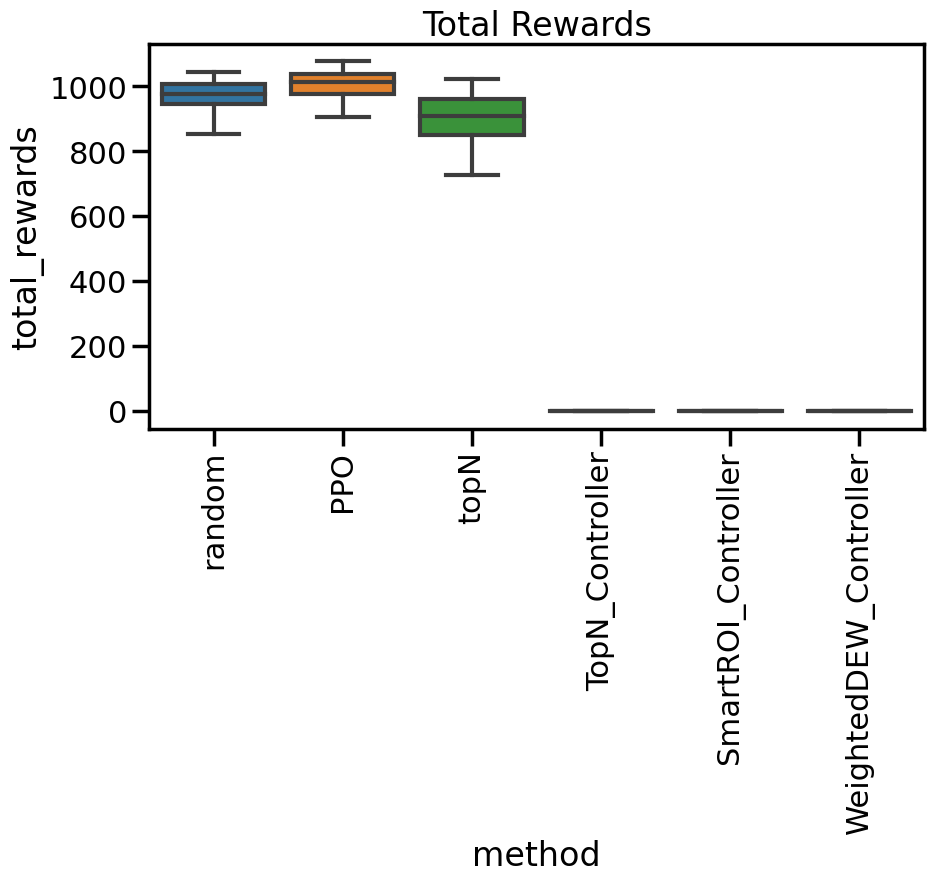

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='total_rewards', showfliers=False)
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

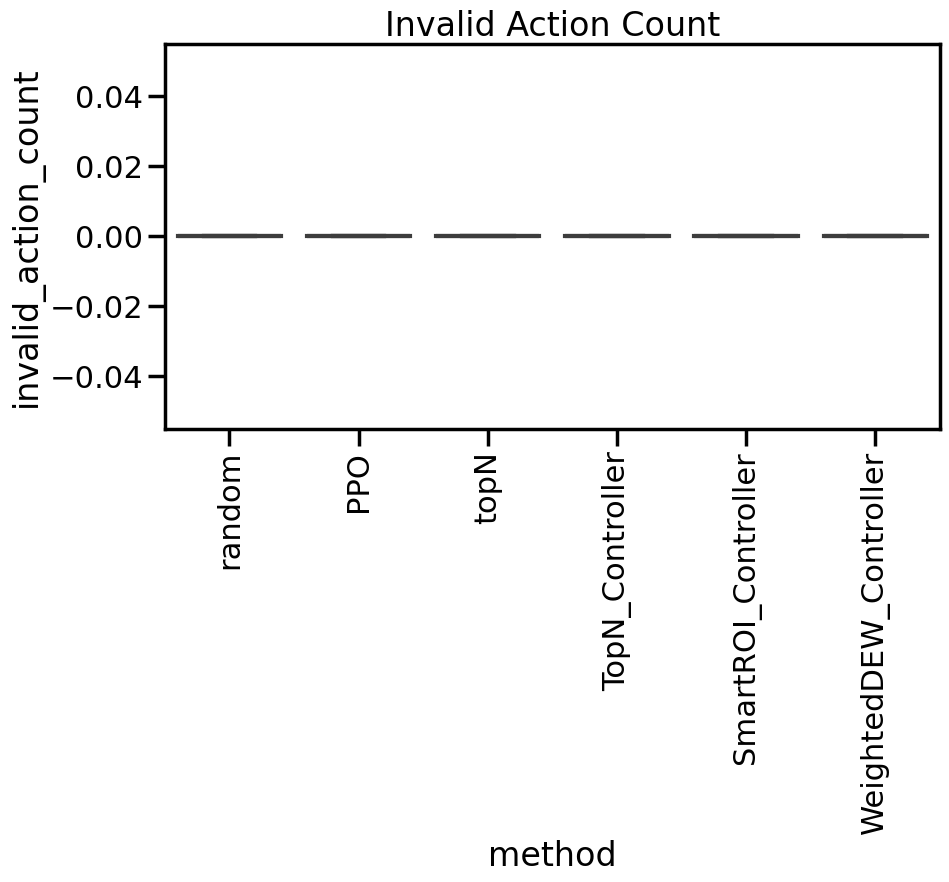

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='invalid_action_count', showfliers=False)
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

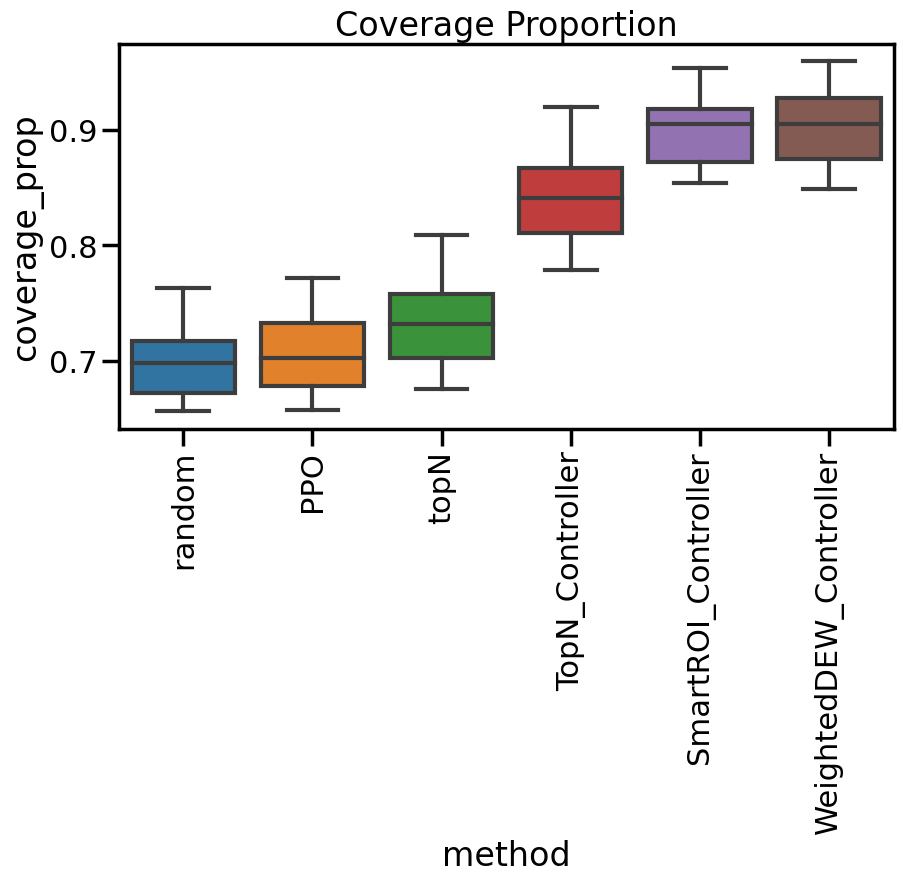

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

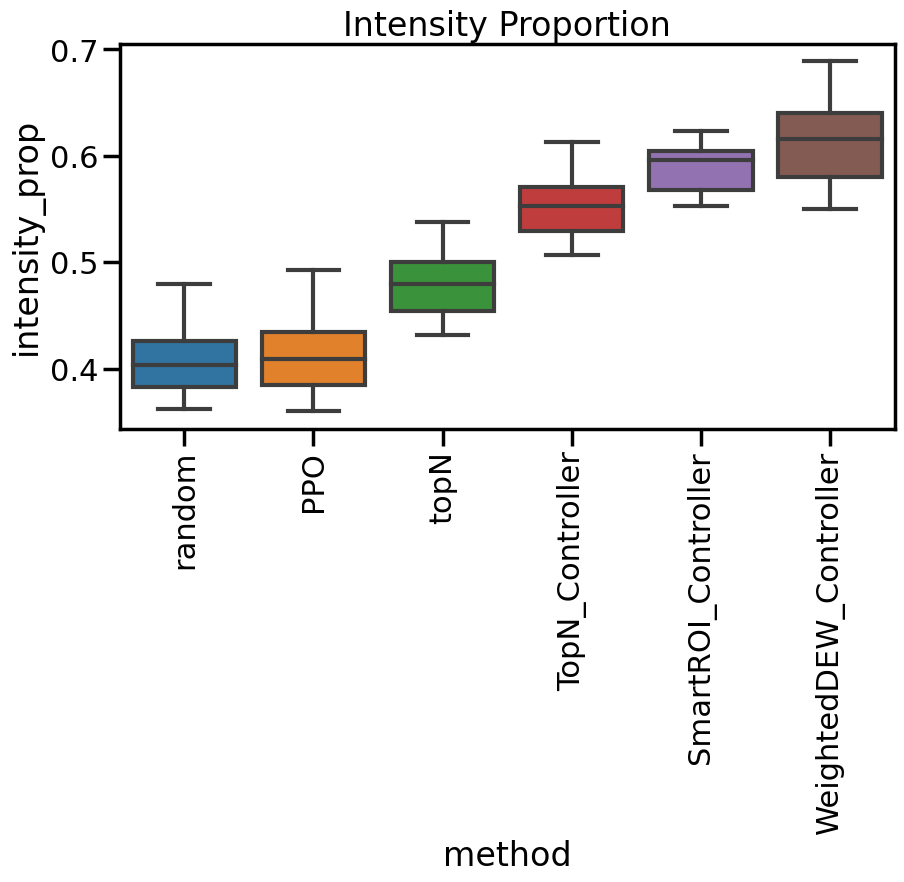

In [41]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

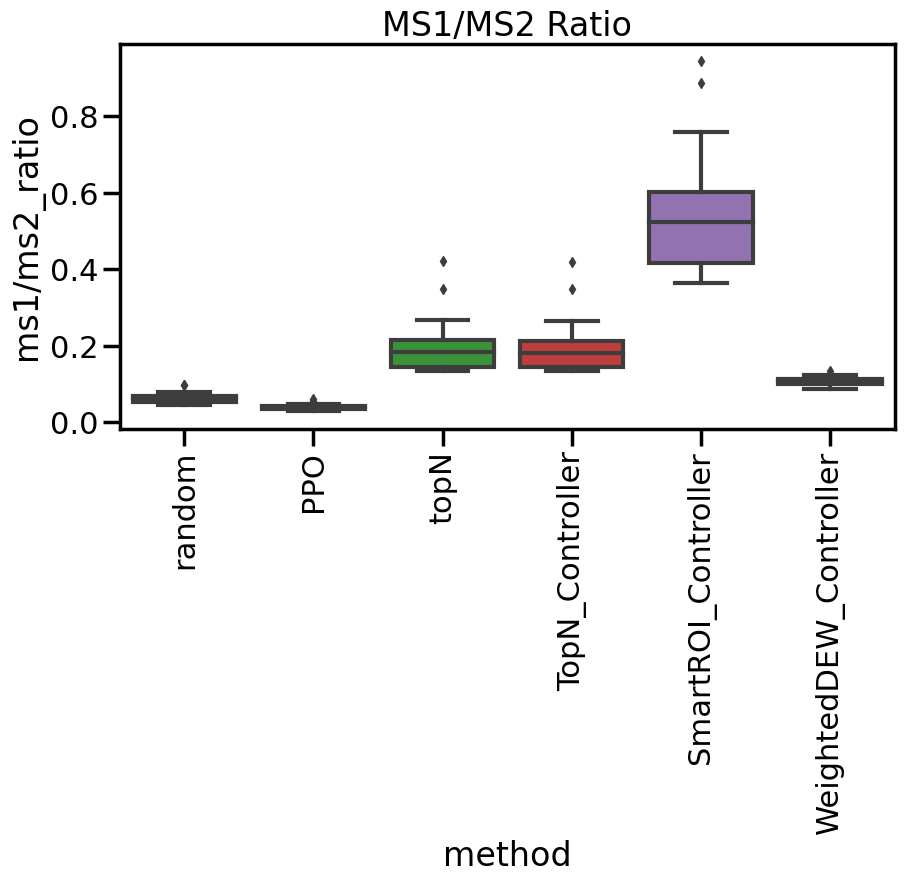

In [42]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Precision')

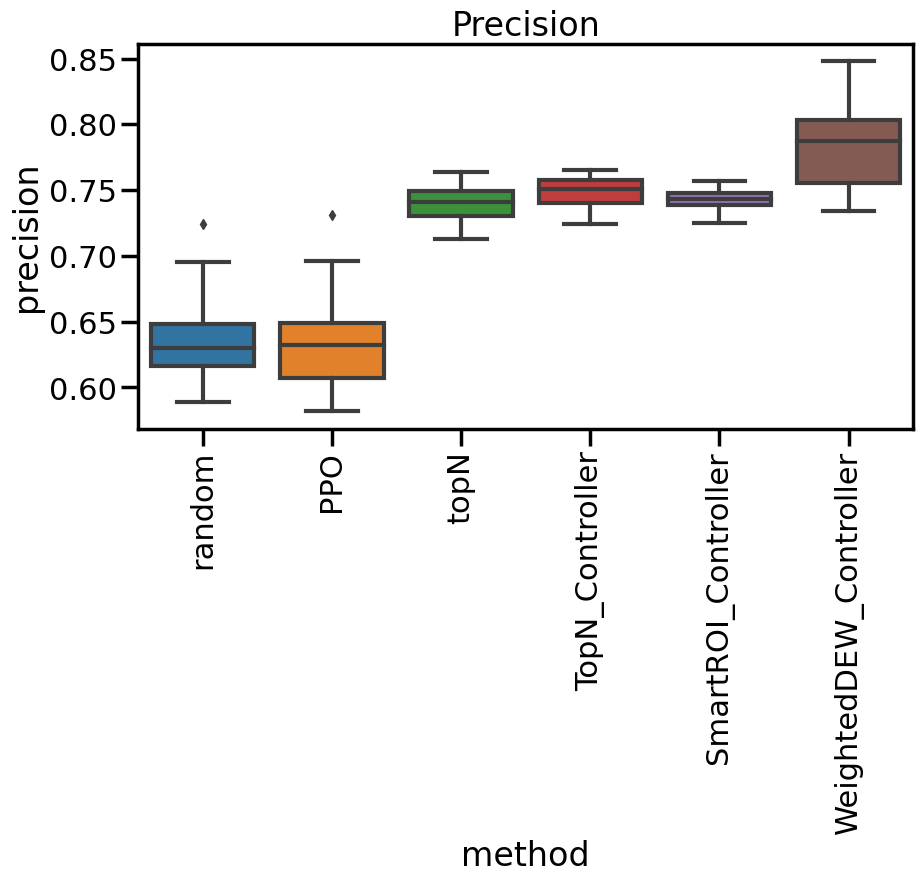

In [43]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

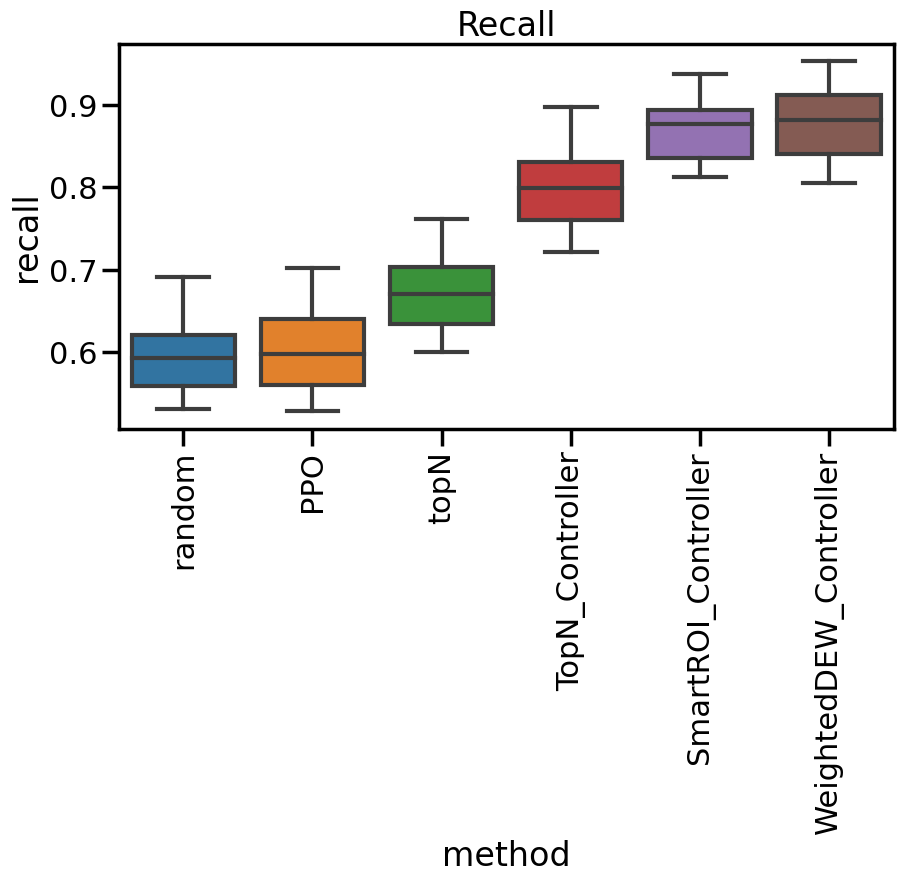

In [44]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

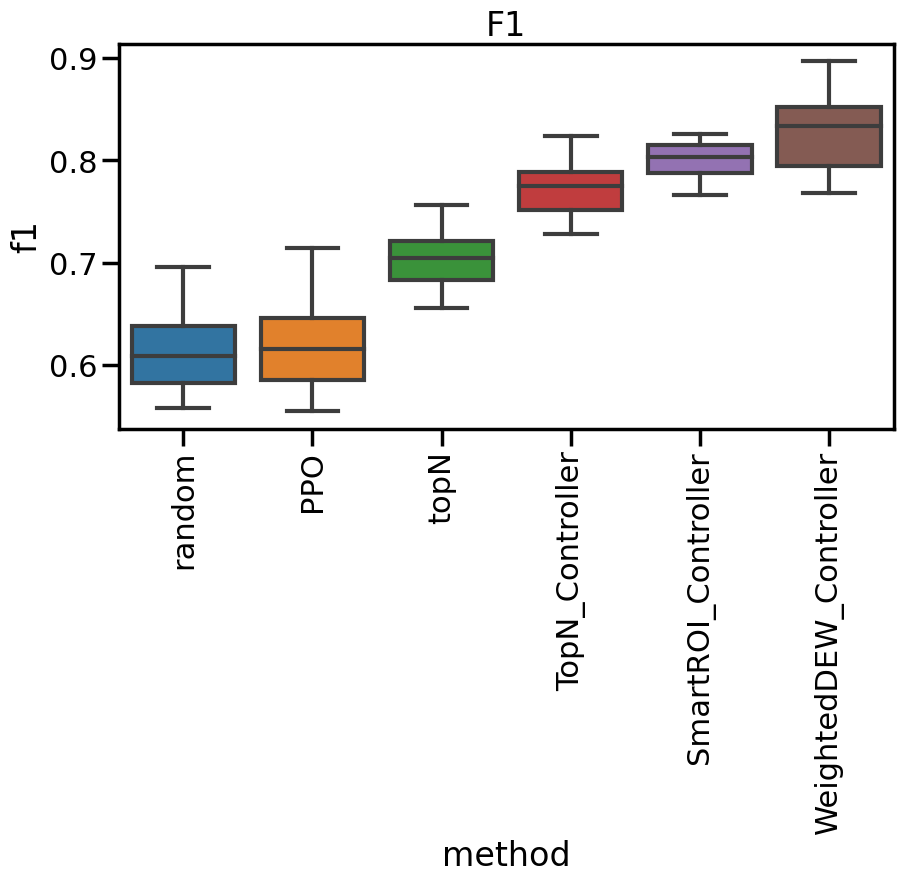

In [45]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')